In [163]:
from typing import List, Optional, Dict, Any
from pydantic import BaseModel, Field


# LangChain imports (unify single API surface)
from langchain.schema import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain import LLMChain
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI


# LangGraph / workflow
from langgraph.graph import StateGraph, END, MessagesState


# CLIP dependencies
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np

# Vector store / embeddings (FAISS)
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings


from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain_core.messages import AIMessage

from typing import Dict, Any
from langchain_core.messages import AIMessage

from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

from typing import Literal
from langgraph.graph import StateGraph, END


# Utilities
from datetime import datetime
import random

In [164]:
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)


def make_chain(system_prompt: str, human_template: str):
  prompt = ChatPromptTemplate.from_messages([
  ("system", system_prompt),
  ("human", human_template)
  ])
  return LLMChain(llm=llm, prompt=prompt)

In [165]:

class SupervisorState(MessagesState):
    messages: List[BaseMessage] = Field(default_factory=list)
    next_agent: str = "supervisor_agent"
    image_path: Optional[str] = None
    user_intent: str = "analysis"  # Add this line

    image_result: Optional[Dict[str, Any]] = None
    image_summary: str = ""
    questionnaire_result: Optional[Dict[str, Any]] = None
    questionnaire_summary: str = ""
    fusion_result: Optional[Dict[str, Any]] = None
    scientific_data: str = ""
    products_data: str = ""
    final_answer: str = ""

    task_complete: bool = False
    current_task: str = ""
    questionnaire_done: bool = False  # Already present
    agent_call_count: int = 1  # You might already have this from previous updates
    questionnaire_answers: Optional[Dict[str, Any]] = None  # Add this line

In [166]:
def create_supervisor_chain():
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """
        You are a SUPERVISOR managing a team of agents in a multi-agent hair analysis and recommendation system.

        **Agents and Responsibilities:**
        1. image_analysis_agent → analyzes uploaded hair images for dryness, oiliness, or split ends.
        2. questionnaire_agent → interprets questionnaire data to assess habits and scalp/hair type.
        3. fusion_agent → merges results from image + questionnaire to determine a unified hair condition.
        4. scientific_data_agent → explains the causes and mechanisms of the detected condition.
        5. products_data_agent → recommends suitable haircare products and routines.
        6. final_answer_agent → generates a final, user-friendly summary or advice.

        **Supervisor Logic:**
        - If no image data → run image_analysis_agent.
        - If no questionnaire data → run questionnaire_agent.
        - If both image and questionnaire data exist but no fusion yet → run fusion_agent.
        - If the user asked for "hair advice" → check if fusion data is ready, then call both:
            - scientific_data_agent (for explanation)
            - products_data_agent (for product recommendations)
        - Once both scientific and product data are ready → run final_answer_agent.
        - If everything is complete → respond with DONE.

        **State:**
        - Has image analysis: {has_image_analysis}
        - Has questionnaire data: {has_questionnaire_data}
        - Has fusion data: {has_fusion_data}
        - Has scientific data: {has_scientific}
        - Has product data: {has_product_info}
        - Has final answer: {has_final_answer}
        - User request: {user_intent}
         

        Respond ONLY with one of:
        image_analysis_agent / questionnaire_agent / fusion_agent / scientific_data_agent / products_data_agent / final_answer_agent / DONE
        """),
        ("human", "{task}")
    ])
    return supervisor_prompt | llm


In [167]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """
    Supervisor enforces a strict step-by-step pipeline with LLM as a minimal fallback.
    Pipeline: image_analysis_agent -> questionnaire_agent -> fusion_agent -> (if advice) scientific_data_agent -> products_data_agent -> final_answer_agent -> END
    """

    # Debugging: Log the current state for inspection
   # print("Supervisor State:", state)  # Full state log

    messages = state["messages"]
    task = messages[-1].content if messages else "No task"

    # --- Extract flags from state (align with agent outputs) ---
    has_image = bool(state.get("image_result"))
    has_questionnaire = bool(state.get("questionnaire_result")) or state.get("questionnaire_done", False)
    has_fusion = bool(state.get("fusion_result"))
    has_scientific = bool(state.get("scientific_data"))
    has_product_info = bool(state.get("products_data"))
    has_final_answer = bool(state.get("final_answer"))

    # --- Detect user intent from the FIRST HumanMessage (not last, to avoid mishaps) ---
    user_intent = "analysis"
    for msg in messages:
        if isinstance(msg, HumanMessage):  # Find the first user message
            latest_text = msg.content.lower()
            if any(w in latest_text for w in ["advice", "recommend", "what should i use", "what shampoo", "routine"]):
                user_intent = "hair_advice"
            elif any(w in latest_text for w in ["why", "cause", "scientific", "explain"]):
                user_intent = "explain"
            break  # Stop at the first human message
   # print(f" Detected user_intent: {user_intent}")  # Debug print

    if state.get("user_intent", "analysis") == "analysis":  # Only detect if not already set
        for msg in messages:
            if isinstance(msg, HumanMessage):
                latest_text = msg.content.lower()
                if any(w in latest_text for w in ["advice", "recommend", "what should i use", "what shampoo", "routine"]):
                    state["user_intent"] = "hair_advice"
                   # print(f" Set user_intent to: {state['user_intent']}")  # Debug print
                elif any(w in latest_text for w in ["why", "cause", "scientific", "explain"]):
                    state["user_intent"] = "explain"
                  #  print(f" Set user_intent to: {state['user_intent']}")  # Debug print
                else:
                    print(f" No keywords found, keeping user_intent as: {state.get('user_intent', 'analysis')}")  # Debug print
                break  # Stop at first HumanMessage
    else:
        print(f" Using persisted user_intent: {state.get('user_intent', 'analysis')}")  # Debug print
    # Use state["user_intent"] instead of local user_intent
    user_intent = state.get("user_intent", "analysis")

    # --- Deterministic routing (primary logic) ---
    next_agent = None
    supervisor_msg = ""

    if has_final_answer:
        next_agent = "end"
        state["task_complete"] = True
        supervisor_msg = " Supervisor: Final answer ready. Ending workflow."
    elif not has_image:
        next_agent = "image_analysis_agent"
        supervisor_msg = "Supervisor: No image analysis found — running image analysis now..."
        if not state.get("image_path"):
            state["image_path"] = r"D:\SIC\codes\Gliss_Agent\split2.jpeg"
    elif not has_questionnaire:
        if not state.get("questionnaire_answers"):
           # print(" Warning: questionnaire_answers is missing in state! Skipping to fusion if possible.")
            if has_image:
                next_agent = "fusion_agent"  # Fallback: try fusion with image only
                supervisor_msg = " Supervisor: Questionnaire answers missing — attempting fusion with image data only..."
            else:
                next_agent = "end"
                supervisor_msg = " Supervisor: No questionnaire or image data. Ending workflow."
        else:
            next_agent = "questionnaire_agent"
            supervisor_msg = " Supervisor: Questionnaire data missing — invoking questionnaire agent..."
    elif has_image and has_questionnaire and not has_fusion:
        next_agent = "fusion_agent"
        supervisor_msg = "Supervisor: Image + questionnaire ready — invoking fusion agent..."
    elif user_intent == "hair_advice" and has_fusion:
        if not has_scientific:
            next_agent = "scientific_data_agent"
            supervisor_msg = " Supervisor: User asked for advice — retrieving scientific context..."
        elif not has_product_info:
            next_agent = "products_data_agent"
            supervisor_msg = "Supervisor: Scientific context ready — retrieving product recommendations..."
        else:
            next_agent = "final_answer_agent"
            supervisor_msg = " Supervisor: Scientific + product info ready — preparing final answer..."
    else:
        # Default: If fusion is done but no advice requested, or all data ready, prepare final answer or end
        if has_fusion and (has_scientific or has_product_info or user_intent == "hair_advice"):
            next_agent = "final_answer_agent"
            supervisor_msg = "✅ Supervisor: Data ready — generating final answer..."
        else:
            next_agent = "end"
            state["task_complete"] = True
            supervisor_msg = "✅ Supervisor: Workflow complete or no further actions needed."

    #print(f" Determined next_agent: {next_agent} (has_fusion: {has_fusion}, has_scientific: {has_scientific}, has_product_info: {has_product_info})")  # Debug print

    # --- LLM Fallback (only if deterministic logic failed or for edge cases) ---
    if not next_agent or next_agent == "end" and not state.get("task_complete"):
        #print(" Using LLM fallback for decision...")
        chain = create_supervisor_chain()
        decision = chain.invoke({
            "task": task,
            "has_image_analysis": has_image,
            "has_questionnaire_data": has_questionnaire,
            "has_fusion_data": has_fusion,
            "has_scientific": has_scientific,
            "has_product_info": has_product_info,
            "has_final_answer": has_final_answer,
            "user_intent": user_intent
        })
        decision_text = getattr(decision, "content", None) or getattr(decision, "text", None) or str(decision)
        decision_text = decision_text.strip().lower()

        #print("🧠 Supervisor Decision (LLM Fallback):", decision_text)

        mapping = {
            "image_analysis_agent": "image_analysis_agent",
            "questionnaire_agent": "questionnaire_agent",
            "fusion_agent": "fusion_agent",
            "scientific_data_agent": "scientific_data_agent",
            "products_data_agent": "products_data_agent",
            "final_answer_agent": "final_answer_agent",
            "done": "end"
        }

        chosen = None
        for key in mapping:
            if key in decision_text:
                chosen = mapping[key]
                break

        # Only override if chosen is valid and not causing a loop (e.g., not going backwards)
        if chosen and chosen != next_agent:
            # Prevent backwards overrides (e.g., don't go to fusion if already done)
            if (chosen == "fusion_agent" and has_fusion) or \
               (chosen in ["scientific_data_agent", "products_data_agent"] and not has_fusion):
                print("LLM override rejected to prevent loop.")
            else:
                next_agent = chosen
                supervisor_msg += f" (LLM override: {chosen})"

    if not next_agent:
        #print(" No valid next_agent determined. Defaulting to end.")
        next_agent = "end"

    return {
        "messages": state["messages"] + [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task,
        "task_complete": state.get("task_complete", False),
        "user_intent": user_intent,  # Add this to persist user_intent in state
    }

In [168]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain_core.messages import AIMessage

# Load CLIP model & processor once (global)
device = "cuda" if torch.cuda.is_available() else "cpu"
try:
    _CLIP_MODEL = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    _CLIP_PROCESSOR = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    print("CLIP model loaded on", device)
except Exception as e:
    _CLIP_MODEL = None
    _CLIP_PROCESSOR = None
    print("Warning: CLIP model not loaded:", e)

# Descriptive prompts for CLIP zero-shot
CONDITION_PROMPTS = [
    "dry hair with rough texture and visible frizz",
    "hair with visible split ends and frayed tips",
    "oily, greasy hair near the scalp with flat roots",
    "healthy hair that looks smooth and shiny",
    "dull hair lacking shine",
    "hair with breakage and snapped ends",
    "color-treated hair (dyed)",
    "bleached hair (lightened and damaged)"
]

# Minimal keyword -> HAIR_LABEL mapping (primary candidate first)
PROMPT_KEYWORD_TO_LABEL = {
    "split": ["Prone to Split Ends", "Damaged & Dry"],
    "frizz": ["Heavily Damaged & Dry", "Damaged & Dry"],
    "dry": ["Heavily Damaged & Dry", "Dry, Damaged", "Brittle & Dull"],
    "oily": ["Long hair with greasy roots", "Normal & Fine"],
    "healthy": ["Normal & Fine", "Normal to Dry"],
    "dull": ["Brittle & Dull"],
    "breakage": ["Heavily Damaged", "Brittle & Dull"],
    "color": ["Dry & Colored", "Colored & Bleached"],
    "bleach": ["Colored & Bleached", "Damaged & Bleached"]
}

def _map_prompt_to_label(prompt_text: str):
    kp = prompt_text.lower()
    for k, labels in PROMPT_KEYWORD_TO_LABEL.items():
        if k in kp:
            return labels[0], labels
    # fallback
    return "Normal to Dry", ["Normal to Dry"]

def analyze_hair_image_clip(image_path: str, top_k: int = 3) -> dict:
    """Run CLIP zero-shot on image and return structured result."""
    if _CLIP_MODEL is None or _CLIP_PROCESSOR is None:
        return {"error": "clip_not_loaded", "predicted_label": None, "confidence": 0.0}
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        return {"error": f"cannot_open_image: {e}", "predicted_label": None, "confidence": 0.0}

    inputs = _CLIP_PROCESSOR(text=CONDITION_PROMPTS, images=image, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = _CLIP_MODEL(**inputs)
    logits_per_image = outputs.logits_per_image  # [1, num_prompts]
    probs = logits_per_image.softmax(dim=1).cpu().numpy()[0]
    ranked_idx = np.argsort(-probs)

    predicted_conditions = [(CONDITION_PROMPTS[i], float(probs[i])) for i in ranked_idx[:top_k]]
    raw_probs = {CONDITION_PROMPTS[i]: float(probs[i]) for i in range(len(CONDITION_PROMPTS))}

    top_prompt, top_prob = predicted_conditions[0]
    predicted_label, candidate_labels = _map_prompt_to_label(top_prompt)

    return {
        "predicted_conditions": predicted_conditions,
        "top_condition": predicted_conditions[0],
        "confidence": round(float(top_prob), 3),
        "predicted_label": predicted_label,
        "candidate_labels": candidate_labels,
        "raw_probs": raw_probs
    }

# image_analysis_agent expected by the workflow
def image_analysis_agent(state: SupervisorState) -> dict:
    """
    Reads state['image_path'] and optional state['questionnaire_answers'],
    analyzes image with CLIP, stores both textual summary (Images_data) and structured result.
    """
    image_path = state.get("image_path", "split2.jpeg")
    q_answers = state.get("questionnaire_answers", None)
    # Run questionnaire classifier only to include any quick notes (not required)
    q_summary_text = ""
    if q_answers:
        try:
            q_struct = classify_hair_type(q_answers)
            # small readable snapshot (for LLM fusion)
            q_summary_text = f"Predicted (questionnaire): {q_struct.get('predicted_label')} (conf={q_struct.get('confidence')})"
            # Also persist structured questionnaire_result for downstream agents
            state["questionnaire_result"] = q_struct
        except Exception:
            q_summary_text = ""

    # Analyze image
    if image_path:
        i_res = analyze_hair_image_clip(image_path)
    else:
        i_res = {"predicted_label": None, "confidence": 0.0}

    # Build human summary used by Fusion Agent (text)
    summary_lines = []
    if q_summary_text:
        summary_lines.append(q_summary_text)
    if i_res and i_res.get("predicted_label"):
        summary_lines.append(f"Predicted (image): {i_res.get('predicted_label')} (conf={i_res.get('confidence')})")
        # add top prompt for more context
        if i_res.get("top_condition"):
            summary_lines.append(f"Image observation: {i_res['top_condition'][0]}")
    if not summary_lines:
        summary_lines = ["Image analysis unavailable or no inputs provided."]

    # Persist textual and structured results for downstream fusion
    human_summary = "\n".join(summary_lines)
    state["Images_data"] = human_summary
    state["image_analysis_result"] = i_res

    # Compose AIMessage and return
    msg = f"🖼️ Image Analysis Agent (CLIP) completed.\n\n{human_summary}"
    if i_res and i_res.get("candidate_labels"):
        msg += "\n\nCandidate labels: " + ", ".join(i_res.get("candidate_labels"))

    return {
        "messages": [AIMessage(content=msg)],
        "Images_data": human_summary,
        "image_result": i_res,
        "next_agent": "supervisor_agent"
    }

# Try to update the workflow node if available (safe)
try:
    workflow.add_node("image_analysis_agent", image_analysis_agent)
    graph = workflow.compile()
    print("image_analysis_agent replaced with CLIP-based agent and workflow recompiled.")
except Exception as e:
    print("Note: could not auto-recompile; re-run the workflow creation cell. Error:", e)


Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


CLIP model loaded on cpu
Note: could not auto-recompile; re-run the workflow creation cell. Error: Node `image_analysis_agent` already present.


In [169]:
from typing import Dict, Any
from langchain_core.messages import AIMessage

def questionnaire_agent(state: SupervisorState) -> Dict:
    """
    Rule-based questionnaire agent.
    It classifies the user's hair type based on questionnaire answers
    using pre-defined conditions and scoring rules.
    """
    
    answers = state.get("questionnaire_answers", {})
  #  print(f"🧾 Questionnaire Agent: Received answers: {answers}")  # Debugging log
    
    if not answers:
        agent_message = "⚠️ Questionnaire Agent: No questionnaire answers provided."
        print("⚠️ Warning: No questionnaire answers; setting as done to break loop.")
        return {
            "messages": [AIMessage(content=agent_message)],
            "next_agent": "supervisor_agent",
            "questionnaire_done": True  # Add this to prevent further loops
        }

    # --- Scoring based on LABEL_RULES ---
    label_scores = {}
    label_explanations = {}

    for label, rules in LABEL_RULES.items():
        total = 0
        reasons = []
        for condition_fn, weight, desc in rules:
            try:
                if condition_fn(answers):
                    total += weight
                    reasons.append(desc)
            except Exception as e:
                print(f"Error in condition_fn: {e}")  # Debugging log for errors
                continue
        if total > 0:
            label_scores[label] = total
            label_explanations[label] = reasons

    # --- Determine top label ---
    if not label_scores:
        top_label = "Normal to Dry"
        confidence = 0.5
        explanation = ["Default classification (insufficient data)"]
    else:
        top_label = max(label_scores, key=label_scores.get)
        max_score = label_scores[top_label]
        total_score = sum(label_scores.values())
        confidence = round(max_score / total_score, 2) if total_score > 0 else 0.7
        explanation = label_explanations[top_label]

    # --- Compose summary text ---
    summary = (
        f"🧾 Questionnaire Agent: Based on your answers, your predicted hair type is:\n\n"
        f"Hair Type: **{top_label}**\n"
        f"Confidence: {confidence * 100:.0f}%\n"
        f"Reasons: {', '.join(explanation)}"
    )

    # --- Update state ---
    state["questionnaire_data"] = summary
    state["questionnaire_result"] = {
        "predicted_label": top_label,
        "confidence": confidence,
        "explanations": explanation
    }

    return {
        "messages": [AIMessage(content=summary)],
        "questionnaire_data": summary,
        "questionnaire_result": {
            "predicted_label": top_label,
            "confidence": confidence,
            "explanations": explanation
        },
        "questionnaire_done": True,  # Ensure this is always set on success
        "next_agent": "supervisor_agent"
    }


In [170]:
# Define the LABEL_RULES constant
LABEL_RULES = {
    "Heavily Damaged & Dry": [
        (lambda a: a.get("heat_styling_frequency_per_week", 0) >= 4, 2, "Frequent heat styling"),
        (lambda a: a.get("uses_chemical_treatment") == "bleach", 2, "Bleach treatment"),
        (lambda a: a.get("split_ends_visible", False), 1, "Visible split ends"),
        (lambda a: a.get("frizz_level", 0) >= 4, 1, "High frizz level"),
    ],
    "Colored & Bleached": [
        (lambda a: a.get("uses_chemical_treatment") in ["bleach", "color"], 2, "Chemical treatment"),
        (lambda a: a.get("shine_level", 5) <= 2, 1, "Low shine"),
    ],
    "Damaged & Dry": [
        (lambda a: a.get("split_ends_visible", False), 1, "Split ends"),
        (lambda a: a.get("shine_level", 5) <= 3, 1, "Below average shine"),
        (lambda a: a.get("uses_heat_styling", False), 1, "Uses heat styling"),
    ],
    "Dry & Colored": [
        (lambda a: a.get("uses_chemical_treatment") == "color", 2, "Color treated"),
        (lambda a: a.get("frizz_level", 0) >= 3, 1, "Some frizz"),
    ],
    "Normal to Dry": [
        (lambda a: a.get("scalp_oiliness", 3) <= 2, 1, "Low scalp oiliness"),
        (lambda a: not a.get("uses_chemical_treatment"), 1, "No chemical treatments"),
    ],
    "Long hair with greasy roots": [
        (lambda a: a.get("scalp_oiliness", 0) >= 4, 2, "Very oily scalp"),
        (lambda a: a.get("hair_length", "") == "long", 1, "Long hair"),
    ]
}

In [171]:

from langchain_core.messages import AIMessage

def fusion_agent(state: SupervisorState) -> Dict:
    """
    Fusion Agent: Combines predictions from questionnaire_agent and image_analysis_agent
    using weighted confidence and agreement logic.
    """

    # 1️Retrieve both results from the shared state
    q_res = state.get("questionnaire_result", {})
    i_res = state.get("image_result", {})

    if not q_res and not i_res:
        msg = "⚠️ Fusion Agent: No data from questionnaire or image analysis agents."
        return {"messages": [AIMessage(content=msg)], "next_agent": "supervisor_agent"}

    if not q_res:
        msg = "Fusion Agent: No questionnaire data found, relying on image analysis only."
        return {
            "final_label": i_res.get("predicted_label", "Unknown"),
            "combined_confidence": i_res.get("confidence", 0.5),
            "reasoning": ["Used only image agent data."],
            "messages": [AIMessage(content=msg)],
            "next_agent": "supervisor_agent"
        }

    if not i_res:
        msg = " Fusion Agent: No image data found, relying on questionnaire only."
        return {
            "final_label": q_res.get("predicted_label", "Unknown"),
            "combined_confidence": q_res.get("confidence", 0.5),
            "reasoning": ["Used only questionnaire agent data."],
            "messages": [AIMessage(content=msg)],
            "next_agent": "supervisor_agent"
        }

    # 2 Extract relevant info
    q_label = q_res.get("predicted_label", "Unknown")
    q_conf = q_res.get("confidence", 0.5)
    i_label = i_res.get("predicted_label", "Unknown")
    i_conf = i_res.get("confidence", 0.5)

    # Define base weights
    q_weight = 0.6
    i_weight = 0.4

    # Adjust weights if image confidence is significantly higher
    if i_conf - q_conf > 0.2:
        i_weight, q_weight = 0.6, 0.4

    # Combine or resolve conflict
    if q_label == i_label:
        # Both agents agree
        final_label = q_label
        combined_confidence = round((q_conf * q_weight + i_conf * i_weight) / (q_weight + i_weight), 3)
        reasoning = [
            f" Both agents agree on '{final_label}'.",
            f"Image confidence: {i_conf}, Questionnaire confidence: {q_conf}"
        ]
    else:
        # Conflict: choose the one with higher weighted confidence
        q_score = q_conf * q_weight
        i_score = i_conf * i_weight
        if q_score >= i_score:
            final_label = q_label
            reasoning = [
                f" Questionnaire suggests '{q_label}' ({q_conf:.2f})",
                f" Image suggests '{i_label}' ({i_conf:.2f})",
                "→ Chose questionnaire result due to stronger evidence from user habits."
            ]
        else:
            final_label = i_label
            reasoning = [
                f" Image suggests '{i_label}' ({i_conf:.2f})",
                f" Questionnaire suggests '{q_label}' ({q_conf:.2f})",
                "→ Chose image result due to clearer visual evidence."
            ]

        combined_confidence = round(abs(q_score - i_score) + max(q_conf, i_conf) / 2, 3)

    #  Compose message
    fusion_summary = (
        f"🤝 **Fusion Agent Result**\n\n"
        f"Final Hair Type: **{final_label}**\n"
        f"Combined Confidence: {combined_confidence * 100:.1f}%\n\n"
        + "\n".join(reasoning)
    )

    # Save to state and return
    state["fusion_result"] = {
        "final_label": final_label,
        "combined_confidence": combined_confidence,
        "questionnaire_result": q_res,
        "questionnaire_done": True, 
        "image_result": i_res,
        "reasoning": reasoning
    }

    return {
        "messages": [AIMessage(content=fusion_summary)],
        "fusion_result": state["fusion_result"],
        "next_agent": "supervisor_agent"
    }


   

In [172]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
embedding_function = OpenAIEmbeddings()
new_db = FAISS.load_local("hair_care_faiss_index",embedding_function ,allow_dangerous_deserialization=True)
new_retriever = new_db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})

In [173]:
def scientific_data_agent(state: SupervisorState) -> Dict:
    """Agent responsible for retrieving relevant scientific data from the vector database."""

    # Get the hair type from fusion or other sources to create a better query
    fusion_result = state.get("fusion_result", {})
    hair_type = fusion_result.get('final_label', 'Unknown')
    questionnaire_result = state.get("questionnaire_result", {})
    explanations = questionnaire_result.get('explanations', [])
    
    # Create a targeted query based on the actual hair condition
    if fusion_result:
        query = f"""
        Scientific information about {hair_type} hair care, including:
        - Causes and mechanisms of {hair_type.lower()}
        - Best treatments for {', '.join(explanations) if explanations else 'hair damage'}
        - Recommended ingredients and their scientific benefits
        - Hair care routine for {hair_type.lower()} hair
        """
    else:
        query = "scientific hair care principles and best practices"

    try:
        # Perform targeted similarity search
        results = new_retriever.invoke(query, k=3)

        # Format the retrieved documents
        documents = "\n\n".join([doc.page_content for doc in results])
        scientific_data = documents

        # Create agent message
        agent_message = f"🔍 Scientific Data Agent: Retrieved scientific data for '{hair_type}' hair condition."

    except Exception as e:
        # Fallback: Provide a generic summary if retriever fails
        print(f"⚠️ Scientific Data Agent Error: {e}. Using fallback summary.")
        scientific_data = f"""
        Scientific insights on {hair_type} hair: 
        This condition typically involves compromised hair structure requiring specialized care. 
        Focus on repairing the hair cuticle, maintaining moisture balance, and protecting from further damage.
        """
        agent_message = f"🔍 Scientific Data Agent: Retriever failed ({e}). Using fallback data."

    return {
        "messages": [AIMessage(content=agent_message)],
        "scientific_data": scientific_data,
        "next_agent": "supervisor_agent"
    }

In [174]:
def products_data_agent(state: SupervisorState) -> Dict:
    """Agent responsible for providing detailed product data."""
    
    try:
        # Hardcoded product data
        products_data = """
        Gliss Haircare – Verified Detailed Overview
        This document combines verified data from Schwarzkopf/Gliss official sources with supplementary
        insights about ingredient benefits. Verified information is based on official product descriptions;
        supplementary details are derived from general cosmetic ingredient knowledge.

        Gliss Ultimate Repair
        Verified Information (from Schwarzkopf/Gliss):
        - Key Ingredients: Black Pearl, Liquid Keratin
        - Effect: Deep reconstruction of very damaged hair, replaces lost keratin, improves resistance and shine.
        - Suitable For: Extremely damaged or dry hair needing intense repair.
        Supplementary Details (based on ingredient properties):
        - Benefits from Ingredients: Enhances elasticity, repairs damage, promotes healthy shine, fortifies cell structure.
        - Fragrance: Sensual Rich
        - Care Level: Deep / Intensive

        Gliss Total Repair
        Verified Information (from Schwarzkopf/Gliss):
        - Key Ingredients: Floral Nectar, Hydrolyzed Keratin
        - Effect: Nourishes and smooths hair, reduces breakage, improves manageability.
        - Suitable For: Dry, stressed, or dull hair.
        Supplementary Details (based on ingredient properties):
        - Benefits from Ingredients: Seals moisture, supports follicle nutrition, restores sebaceous secretion balance.
        - Fragrance: Cocooning Musk
        - Care Level: Deep / Intensive

        Gliss Oil Nutritive
        Verified Information (from Schwarzkopf/Gliss):
        - Key Ingredients: Marula Oil, Omega 9
        - Effect: Enriched with beauty oils and keratin for 90% fewer split ends, restores from root to tip without heaviness.
        - Suitable For: Long, frizzy, or stressed hair requiring nourishment.
        Supplementary Details (based on ingredient properties):
        - Benefits from Ingredients: Provides follicle nourishment, controls water loss, eliminates split ends.
        - Fragrance: Sensual Rich
        - Care Level: Medium

        Gliss Aqua Revive
        Verified Information (from Schwarzkopf/Gliss):
        - Key Ingredients: Marine Algae, Hyaluron Complex
        - Effect: Hydrating formula that restores moisture balance, softens, and revitalizes the hair.
        - Suitable For: Normal to dry hair needing light hydration.
        Supplementary Details (based on ingredient properties):
        - Benefits from Ingredients: Maintains moisture barrier, nourishes follicles, seals moisture.
        - Fragrance: Green Fragrance
        - Care Level: Gentle

        Gliss Supreme Length
        Verified Information (from Schwarzkopf/Gliss):
        - Key Ingredients: Peony Flower, Biotin Complex
        - Effect: Strengthens long hair, repairs split ends, supports healthy growth.
        - Suitable For: Long hair with weak or damaged ends.
        Supplementary Details (based on ingredient properties):
        - Benefits from Ingredients: Restores moisture, increases follicle strength, supports healthy hair growth.
        - Fragrance: Fruity
        - Care Level: Gentle
        """
        
        agent_message = "🛍 Products Data Agent: I've provided detailed product information."
    
    except Exception as e:
        print(f"Products Data Agent Error: {e}. Using fallback.")
        products_data = "Fallback: Recommend repair products like shampoos with keratin for damaged hair."
        agent_message = f"🛍 Products Data Agent: Error occurred ({e}). Using fallback recommendations."
    
    # Update the state with product data
    state["products_data"] = products_data
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "products_data": products_data,
        "next_agent": "supervisor_agent"
    }

In [175]:
def final_answer_agent(state: SupervisorState) -> Dict:
    """
    Uses a proper LangChain chain for dynamic, structured final answers.
    """
    # Extract all data
    fusion_result = state.get("fusion_result", {})
    scientific_data = state.get("scientific_data", "")
    products_data = state.get("products_data", "")
    questionnaire_result = state.get("questionnaire_result", {})
    
    hair_type = fusion_result.get('final_label', 'Unknown')
    explanations = questionnaire_result.get('explanations', [])
    confidence = fusion_result.get('combined_confidence', 0)
    
    # Create a proper chain for dynamic generation
    final_chain = make_chain(
        system_prompt="""You are a hair care expert creating personalized analysis reports. 
        Create comprehensive, dynamic reports that synthesize all available data.
        Always tailor recommendations to the specific hair type and available scientific data.
        Be specific, practical, and encouraging.""",
        
        human_template="""Create a complete hair analysis report using this data:
        
        HAIR TYPE: {hair_type}
        CONFIDENCE: {confidence}
        KEY FACTORS: {key_factors}
        SCIENTIFIC DATA: {scientific_data}
        PRODUCTS INFORMATION: {products_data}
        
        Please generate a report that includes:
        1. Personalized hair condition summary
        2. Product recommendations with specific reasoning
        3. Scientific-based care advice  
        4. Practical weekly routine
        5. Expected outcomes
        
        Make it dynamic and tailored to this specific hair type."""
    )
    
    try:
        response = final_chain.invoke({
            "hair_type": hair_type,
            "confidence": f"{confidence:.1%}",
            "key_factors": ', '.join(explanations) if explanations else 'Comprehensive analysis',
            "scientific_data": scientific_data[:800] if scientific_data else 'General hair care principles',
            "products_data": products_data[:1000] if products_data else 'Professional hair care products'
        })
        
        final_answer = response["text"]
        
    except Exception as e:
        print(f"⚠ Final Answer Agent Error: {e}")
        final_answer = create_fallback_response(
            hair_type, explanations, scientific_data, products_data, confidence
        )
    
    return {
        "messages": [AIMessage(content=final_answer.strip())],
        "final_answer": final_answer.strip(),
        "task_complete": True,
        "next_agent": END
    }

In [176]:
from typing import Literal
from langgraph.graph import StateGraph, END

def router(state: dict):
    next_agent = state.get("next_agent", "")
    #print(f" Router: next_agent = '{next_agent}', task_complete = {state.get('task_complete', False)}")  # Debug print
    if next_agent == "end" or state.get("task_complete"):
        return END
    return next_agent


workflow = StateGraph(SupervisorState)

workflow.add_node("supervisor_agent", supervisor_agent)
workflow.add_node("image_analysis_agent", image_analysis_agent)
workflow.add_node("questionnaire_agent", questionnaire_agent)
workflow.add_node("fusion_agent", fusion_agent)
workflow.add_node("scientific_data_agent", scientific_data_agent)
workflow.add_node("products_data_agent", products_data_agent)
workflow.add_node("final_answer_agent", final_answer_agent)
workflow.add_edge("final_answer_agent", END)

workflow.set_entry_point("supervisor_agent")

workflow.add_conditional_edges(
    "supervisor_agent",
    router,
    {
        "image_analysis_agent": "image_analysis_agent",
        "questionnaire_agent": "questionnaire_agent",
        "fusion_agent": "fusion_agent",
        "scientific_data_agent": "scientific_data_agent",
        "products_data_agent": "products_data_agent",
        "final_answer_agent": "final_answer_agent",
        END: END,
    },
)

for node in [
    "image_analysis_agent",
    "questionnaire_agent",
    "fusion_agent",
    "scientific_data_agent",
    "products_data_agent",
]:
    workflow.add_edge(node, "supervisor_agent")

graph = workflow.compile()
print("Workflow graph compiled successfully.")


Workflow graph compiled successfully.


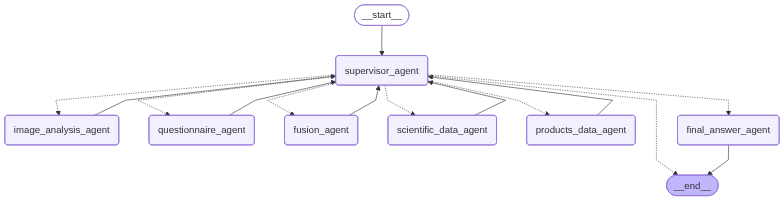

In [177]:
graph

In [178]:
from langchain_core.messages import HumanMessage

# Example answers 
example_answers = {
    "wash_frequency_per_week": 3,
    "uses_heat_styling": True,
    "heat_styling_frequency_per_week": 4,
    "uses_chemical_treatment": "bleach",
    "split_ends_visible": True,
    "scalp_oiliness": 2,
    "shine_level": 2,
    "frizz_level": 4,
    "hair_thickness": "medium",
    "hair_texture": "wavy",
    "hair_length": "long",
    "tip_condition": "dry"
}

# Create initial state
initial_state = SupervisorState(
    messages=[HumanMessage(content="Analyze my hair condition and recommend care routine.")],
    questionnaire_answers=example_answers,
    image_path="test.png",
    agent_call_count=1
)

print("🚀 Starting hair analysis workflow...")
print("Please wait while we analyze your hair condition...\n")

# Run the workflow
graph = workflow.compile()
result = graph.invoke(initial_state)

# Clear output and show only the final result
print("\n" + "="*80)
print("🎉 YOUR PERSONALIZED HAIR ANALYSIS RESULTS")
print("="*80)

final_answer = result.get("final_answer", "No final answer generated.")
print(final_answer)
print("="*80)

🚀 Starting hair analysis workflow...
Please wait while we analyze your hair condition...

 Using persisted user_intent: hair_advice
 Using persisted user_intent: hair_advice
 Using persisted user_intent: hair_advice
 Using persisted user_intent: hair_advice
 Using persisted user_intent: hair_advice


C:\Users\DELL\AppData\Local\Temp\ipykernel_30728\690074089.py:9: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  return LLMChain(llm=llm, prompt=prompt)



🎉 YOUR PERSONALIZED HAIR ANALYSIS RESULTS
**Personalized Hair Condition Summary:**

Your hair type is characterized as normal and fine, which typically means it has a balanced oil production but is more prone to damage due to its finer texture. Currently, your hair is facing challenges due to frequent heat styling, bleach treatments, visible split ends, and a high level of frizz. These factors contribute to a weakened hair structure, making it more susceptible to further damage. The scientific data suggests that such mechanical and chemical stressors can lead to dryness, tangling, and increased split ends, particularly in fine hair, which lacks the robustness of thicker strands.

**Product Recommendations with Specific Reasoning:**

1. **Gliss Ultimate Repair:**
   - **Reasoning:** Given your hair's exposure to frequent heat styling and bleach treatments, this product is highly suitable. Its key ingredients, Black Pearl and Liquid Keratin, are designed to deeply reconstruct very damag